<a href="https://colab.research.google.com/gist/jonghank/04edf9426489582d5c4dd56657fcd9fa/waypoint_guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waypoint guidance


$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

$$
\begin{aligned}
  x_{t+1} &= Ax_t + Bu_t 
\end{aligned}
$$

where $u_t\in\R^m$ is a control input to the dynamical system (say, a drive force or steering force on the vehicle). $A$ is the state transition matrix, $B$ is the input matrix.

Given $A$ and $B$, the goal is to find the optimal $u_0, \dots, u_{N-1}$ that drives the systems state to the desirable state at the final time, $x_N= x_\text{des}$, while minimizing the size of $u_0, \dots, u_N$.

<br>

A minimum energy controller finds $u_t$ by solving the following optimization problem 

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|^2  \\
  \text{subject to} \quad & x_N = x_{\text{des}} \\
  \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$

We'll apply a minimum energy control to a vehicle guidance problem with state $x_t\in\R^4$, where the first two states are the position of the vehicle in two dimensions, and the last two are the vehicle velocity. The vehicle's control $u_t\in\R^2$ is acceleration control for the two axes.

Then the following matrices describe the above dynamics.

$$
A = \bmat{
1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1-0.5\gamma\Delta t\right)\Delta t \\
0 & 0 & 1-\gamma\Delta t & 0 \\
0 & 0 & 0 & 1-\gamma\Delta t
} \\
B = \bmat{
0.5\Delta t^2 & 0 \\
0 & 0.5\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
} 
$$



In [2]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,n+1)
delt = T/n
gamma = .05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt


<br> 

Instead of the terminal constraints, $x_N = x_\text{des}$, we will impose constraints on positions at several intermediate times, $t_1 < t_2 < \cdots < t_K = N$. More specifically, we will let $w_1, w_2, \dots, w_K\in\R^2$ be the $K$ _waypoints_, by which the vehicle needs to pass at $t_1,  t_2, \dots t_K$. If we let $y_t = Cx_t$ be the position of the vehicle at time $t$ with $C$ being the selection matrix which chooses the first two state variables

$$
  C = \bmat{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 }
$$

the waypoint constraints can be described by

$$
\begin{aligned}
  y_{t_1} &= Cx_{t_1} = w_1  \\
  y_{t_2} &= Cx_{t_2} = w_2  \\
  &\qquad \vdots \\
  y_{t_K} &= Cx_{t_K} = w_K  
\end{aligned}
$$

with $C$ being the selection matrix which chooses the first two state variables (the positions),

<br>

So the waypoint guidance problem can be formulated as follows.

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|^2  \\
  \text{subject to} \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1\\
  \quad & y_{t_k} = w_k, \qquad & k=1,\dots, K
\end{aligned}
$$


<br>

Now we will transform the minimum energy control problem to the standard least norm problem. Note the following relations.

$$
\begin{aligned}
  y_1 &= CAx_0 + CBu_0 \\
  y_2 &= CAx_1 + CBu_1 \\
  &= CA(Ax_0 + Bu_0) + CBu_1 \\
  &= CA^2 x_0 + CAB u_0 + CBu_1 \\
  y_3 &= CAx_2 + CBu_2 \\
  &= CA(Ax_1 + Bu_1) + CBu_2 \\
  &= CA^2x_1 + CAB u_1 + CBu_2 \\
  &= CA^2(Ax_0+Bu_0) + CAB u_1 + CBu_2 \\
  &= CA^3x_0 + CA^2Bu_0 + CABu_1 + CBu_2  
\end{aligned}
$$

and in general
$$
y_t = CA^tx_0 + \bmat{CA^{t-1}B & CA^{t-2}B & \cdots & CAB & CB} 
\bmat{u_0 \\u_1 \\ \vdots \\ u_{t-2} \\ u_{t-1}}
$$

which implies that $x_t$ is affine function of $u_0, \dots, u_{t-1}$.

<br>

Stacking the above relation for all $t=0,\dots,N$, you will essentially have

$$
\bmat{y_1 \\ y_2 \\ \vdots \\ y_{N}}
=
\underbrace{
\bmat{CA \\ CA^2 \\ \vdots \\ CA^{N}}
}_{G}
x_0
+ 
\underbrace{
\bmat{
CB& \\ 
CAB & CB \\ 
\vdots        & \ddots        &          & \ddots &    \\
CA^{N-1}B & CA^{N-2}B & \cdots & CAB & CB}
}_{H}
\bmat{u_0 \\ u_1 \\ \vdots \\ u_{N-1}}
$$

which we simply say

$$
y = Gx_0 + Hu
$$

The waypoint constraints can be stated by

$$
\bmat{y_{t_1} \\ y_{t_2} \\ \vdots \\ y_{t_K}} = Sy= SGx_0 + SH u
= \bmat{w_{1} \\ w_{2} \\ \vdots \\ w_{K}}
$$

where $S\in\R^{2K\times 2N}$ is some selection matrix that chooses $y_{t_1},y_{t_2},\dots, y_{t_K}$ from $y$.

<br>

Now the waypoint guidance problem is 

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \|u\|^2 \\
  \text{subject to} \quad & SHu = w - SGx_0
\end{aligned}
$$

This is just a simple least norm problem.

We consider the finite horizon of $T=50$, with $\Delta t=0.05$.

In [3]:
import scipy.sparse as ssp
import scipy.sparse.linalg as sla

C = np.array([[1,0,0,0],[0,1,0,0]])

x_0 = np.array([10, -20, 30, -10])

K = 3
tk = np.array([ 300, 600, 1000])-1
wp = np.array([[100,  50,  100],
               [  0,  50,   50]])


G = np.zeros( (2*n,4) )
for i in range(n):
  G[2*i:2*(i+1),:] = C@np.linalg.matrix_power(A,i+1)
  
H = np.zeros( (2*n,2*n) )
H_first = np.zeros( (2*n,2) )
for i in range(n):
  H_first[2*i:2*(i+1),:] = C@np.linalg.matrix_power(A,i)@B
for i in range(n):
  H[2*i:,2*i:2*(i+1)] = H_first[:2*(n-i),:]

S = np.zeros( (2*K,2*n))
for k in range(K):
  S[2*k:2*k+2,2*tk[k]:2*tk[k]+2] = np.eye(2)
  
u_hat = sla.lsqr(S@H,wp.T.flatten() - S@G@x_0)[0]

In [4]:
u_vec = u_hat

u_opt = u_vec.reshape(1000,2).T

x = np.zeros((4,n+1))
x[:,0] = x_0

for t in range(n):
    x[:,t+1] = A.dot(x[:,t]) + B.dot(u_opt[:,t])

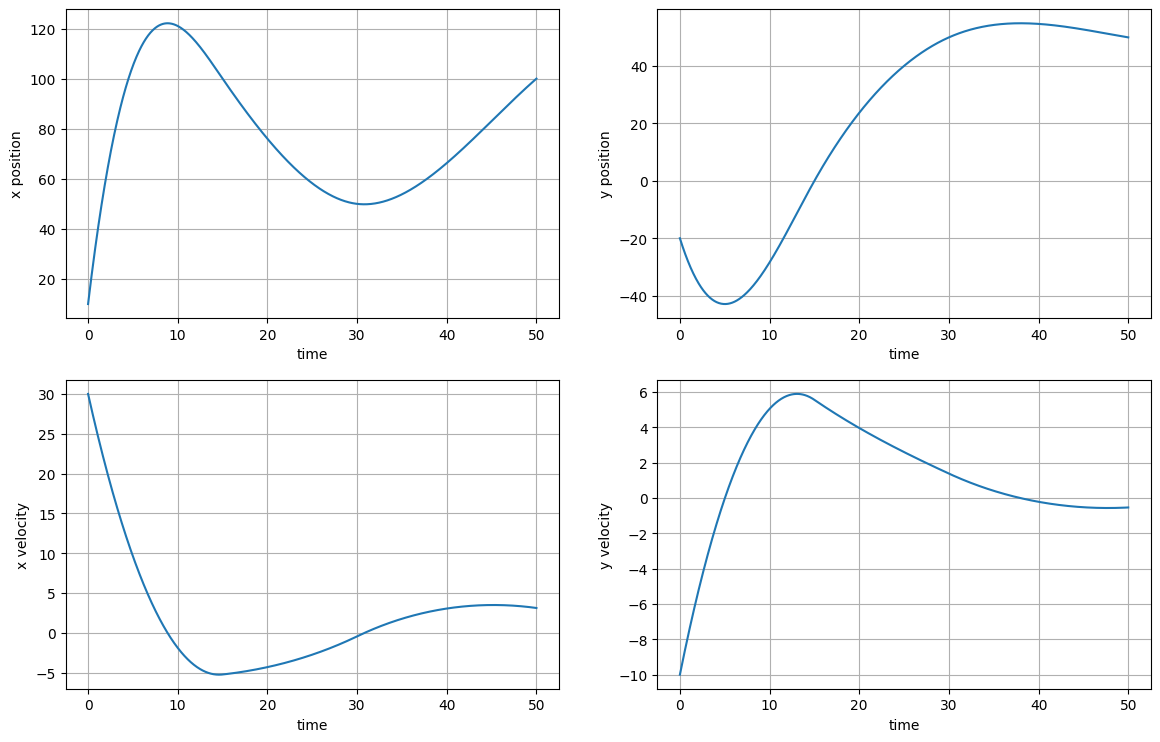

In [5]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x[0,:])
plt.xlabel('time')
plt.ylabel('x position')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

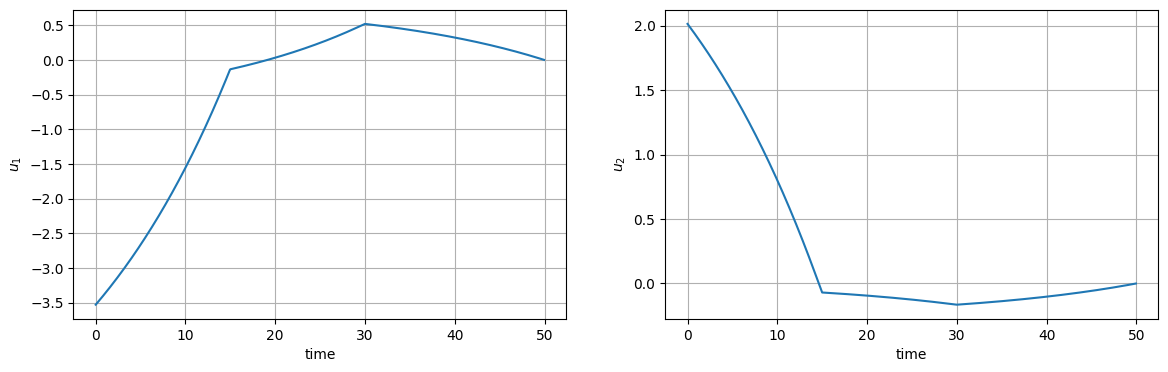

In [6]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts[:-1],u_opt[0,:])
plt.xlabel('time')
plt.ylabel(r'$u_1$')
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts[:-1],u_opt[1,:])
plt.xlabel('time')
plt.ylabel(r'$u_2$')
plt.grid()
plt.show()

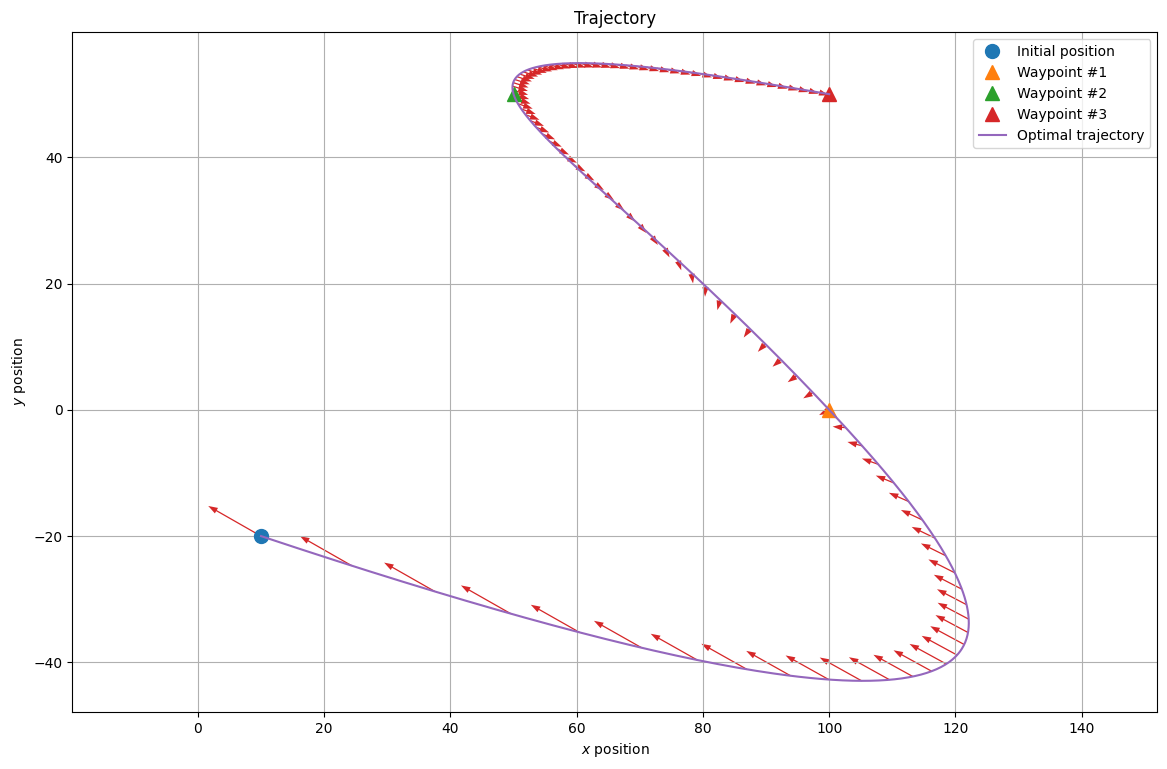

In [19]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_0[0], x_0[1], 'o', markersize=10, label='Initial position')
for k in range(K):
  plt.plot(wp[0,k], wp[1,k], '^', markersize=10, label=f'Waypoint #{k+1}')
plt.title('Trajectory')
plt.plot(x[0,:],x[1,:], label='Optimal trajectory')
plt.legend()
for i in range(0,n-1,10):
  plt.arrow(x[0,i], x[1,i], 2*u_opt[0,i], 2*u_opt[1,i], head_width=1, width=0.2, fc='tab:red', ec='none')
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()

<br> 

The above solution finds the minimum energy trajectory that exactly passes the three waypoints, $w_1$, $w_2$, and $w_3$. Now what if we allow a reasonable amount of position error in passing $w_1$ and $w_2$? Note that these are the intermediate waypoints, and the most of the UAV missions do not require the UAV to exactly pass them.

<br> 

Instead of the original problem, we consider the following problem with some positive $\lambda_1,\dots,\lambda_K$,

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \sum_{t=0}^{N-1} \|u_t\|^2 
  + \sum_{k=1}^{K} \lambda_k \|y_{t_k} - w_k \|^2 \\
  \text{subject to} \quad & x_{t+1} = Ax_t + Bu_t, \qquad & t=0,\dots,N-1
\end{aligned}
$$

which is equivalent to

$$
\begin{aligned}
  \underset{u}{\minimize} \quad & \|u\|^2 + \| W\left(SHu - (w-SGx_0)\right) \|^2
\end{aligned}
$$

with some diagonal matrix $W$ with $(\sqrt{\lambda_1},\sqrt{\lambda_1},\dots,\sqrt{\lambda_K},\sqrt{\lambda_K})$ on the diagonals.
This is again equivalent to the following:

$$
\begin{aligned}
  \underset{x}{\minimize} \quad& \left\| \bmat{I \\ WSH}u-\bmat{0\\W(w-SGx_0)} \right\|^2
\end{aligned}
$$

... a least squares problem.


In [55]:
W = 1*ssp.diags([1, 1, 1, 1, 10, 10])
A_tilde = ssp.vstack((ssp.eye(2*n), W@S@H))
y_tilde = np.hstack((np.zeros(2*n), W@(wp.T.flatten() - S@G@x_0))) 

u_hat_rlx = sla.lsqr(A_tilde, y_tilde)[0]

u_vec_rlx = u_hat_rlx

u_opt_rlx = u_vec_rlx.reshape(1000,2).T

x_rlx = np.zeros((4,n+1))
x_rlx[:,0] = x_0

for t in range(n):
    x_rlx[:,t+1] = A.dot(x_rlx[:,t]) + B.dot(u_opt_rlx[:,t])

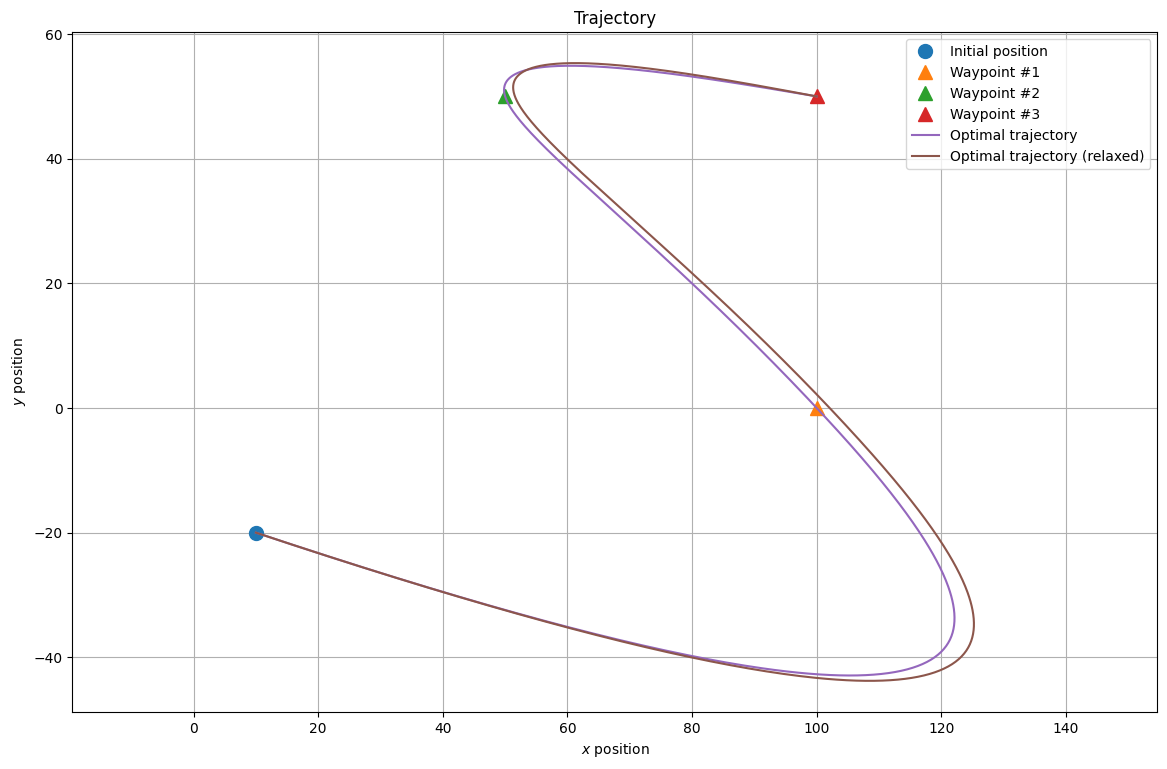

In [56]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_0[0], x_0[1], 'o', markersize=10, label='Initial position')
for k in range(K):
  plt.plot(wp[0,k], wp[1,k], '^', markersize=10, label=f'Waypoint #{k+1}')
plt.plot(x[0,:],x[1,:], label='Optimal trajectory')
plt.plot(x_rlx[0,:],x_rlx[1,:], label='Optimal trajectory (relaxed)')
plt.title('Trajectory')
plt.legend()
plt.axis('equal')
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.grid()
plt.show()